In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchsummary import summary

import matplotlib.pyplot as plt

In [2]:
# ToTensor() turns images to tensors and scales pixels from [0, 255] to [0, 1].
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="./", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, transform=transform, download=True)

train_dataset, val_dataset = random_split(train_dataset, [54000, 6000])

In [3]:
print("Single Image: ", train_dataset[0][0].shape)

Single Image:  torch.Size([1, 28, 28])


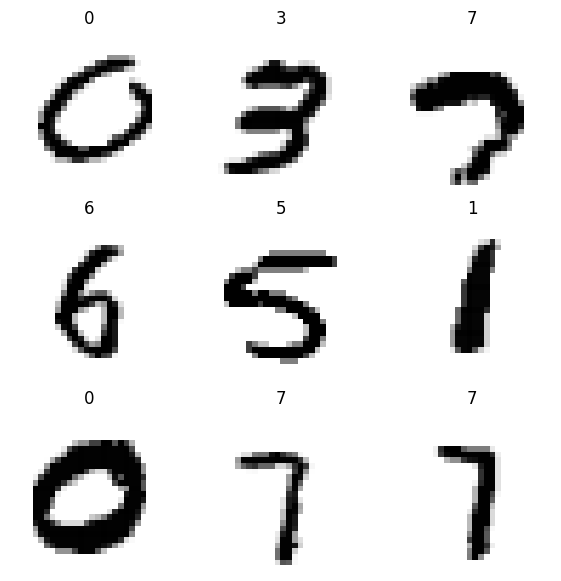

In [4]:
plt.figure(figsize=(7, 7))

for i in range(9):
  plt.subplot(3, 3, i + 1)
  image, label = train_dataset[i]
  plt.imshow(image.squeeze(), cmap=plt.cm.binary)
  plt.title(label)
  plt.axis(False)

In [5]:
# Mini-batch Stochastic Gradient Descent.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(val_dataset,  batch_size=64, drop_last=True)
test_dataloader  = DataLoader(test_dataset, batch_size=64, drop_last=True)

In [6]:
print("Number of training batches: ", len(train_dataloader))

Number of training batches:  843


In [7]:
model = nn.Sequential(
    # Flatten image [1, 28, 28] --> [784]
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
    # nn.CrossEntropyLoss() does the softmax for us.
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [9]:
epochs = 10

train_losses_average_per_epoch = []
train_accuracies_average_per_epoch = []
val_losses_average_per_epoch = []
val_accuracies_average_per_epoch = []

for current_epoch in range(epochs):

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    for train_images_batch, train_labels_batch in train_dataloader:

        # Forward pass.
        outputs = model(train_images_batch)
        loss = loss_fun(outputs, train_labels_batch)

        # Backpropagation.
        loss.backward() # Compute gradients.
        optimizer.step() # Update weights.
        optimizer.zero_grad() # Update gradients to 0 for start of next batch.

        # Batch Loss.
        cumulative_loss_current_epoch += loss.item()

        # Batch Accuracy.
        preds = torch.argmax(outputs, dim=1)
        num_correct_preds = (preds == train_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(train_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

    train_loss_average_current_epoch = cumulative_loss_current_epoch / len(train_dataloader)
    train_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(train_dataloader)

    train_losses_average_per_epoch.append(train_loss_average_current_epoch)
    train_accuracies_average_per_epoch.append(train_accuracy_average_current_epoch)

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    with torch.no_grad():
        for val_images_batch, val_labels_batch in val_dataloader:

            # No Backpropagation, because we do not want to train with the val_dataset.
            outputs = model(val_images_batch)
            loss = loss_fun(outputs, val_labels_batch)

            # Batch Loss.
            cumulative_loss_current_epoch += loss.item()

            # Batch Accuracy.
            preds = torch.argmax(outputs, dim=1)
            num_correct_preds = (preds == val_labels_batch).sum().item()
            batch_accuracy = num_correct_preds / len(val_labels_batch)
            cumulative_accuracy_current_epoch += batch_accuracy

    val_loss_average_current_epoch = cumulative_loss_current_epoch / len(val_dataloader)
    val_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(val_dataloader)

    val_losses_average_per_epoch.append(val_loss_average_current_epoch)
    val_accuracies_average_per_epoch.append(val_accuracy_average_current_epoch)

    print(
        f'Epoch {current_epoch + 1}  '
        f'Train Loss: {train_losses_average_per_epoch[current_epoch]:.2f} '
        f'Train Accuracy: {train_accuracies_average_per_epoch[current_epoch]:.2f} '
        f'Val Loss: {val_losses_average_per_epoch[current_epoch]:.2f} '
        f'Val Accuracy: {val_accuracies_average_per_epoch[current_epoch]:.2f}'
    )

Epoch 1  Train Loss: 0.45 Train Accuracy: 0.88 Val Loss: 0.28 Val Accuracy: 0.92
Epoch 2  Train Loss: 0.23 Train Accuracy: 0.93 Val Loss: 0.20 Val Accuracy: 0.94
Epoch 3  Train Loss: 0.17 Train Accuracy: 0.95 Val Loss: 0.16 Val Accuracy: 0.95
Epoch 4  Train Loss: 0.14 Train Accuracy: 0.96 Val Loss: 0.14 Val Accuracy: 0.96
Epoch 5  Train Loss: 0.12 Train Accuracy: 0.97 Val Loss: 0.12 Val Accuracy: 0.96
Epoch 6  Train Loss: 0.10 Train Accuracy: 0.97 Val Loss: 0.11 Val Accuracy: 0.97
Epoch 7  Train Loss: 0.09 Train Accuracy: 0.98 Val Loss: 0.11 Val Accuracy: 0.97
Epoch 8  Train Loss: 0.08 Train Accuracy: 0.98 Val Loss: 0.10 Val Accuracy: 0.97
Epoch 9  Train Loss: 0.07 Train Accuracy: 0.98 Val Loss: 0.10 Val Accuracy: 0.97
Epoch 10  Train Loss: 0.06 Train Accuracy: 0.98 Val Loss: 0.08 Val Accuracy: 0.97


In [10]:
cumulative_accuracy_current_epoch = 0

with torch.no_grad():
    for test_images_batch, test_labels_batch in test_dataloader:

        outputs = model(test_images_batch)

        # Batch Accuracy.
        preds = torch.argmax(outputs, dim=1)
        num_correct_preds = (preds == test_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(test_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

print(f'Final test accuracy: {cumulative_accuracy_current_epoch / len(test_dataloader):.2%}')

Final test accuracy: 97.50%


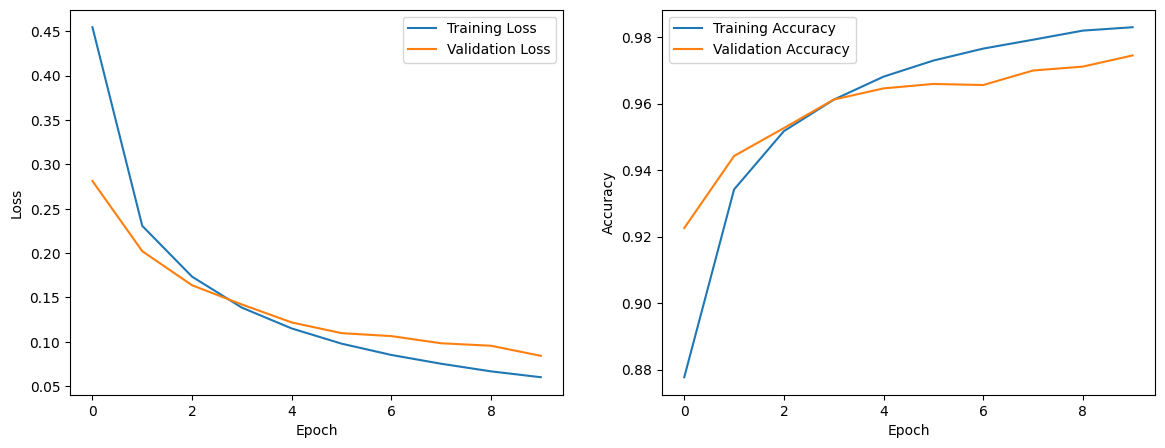

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

metrics = [
    (train_losses_average_per_epoch, val_losses_average_per_epoch, 'Loss'),
    (train_accuracies_average_per_epoch, val_accuracies_average_per_epoch, 'Accuracy')
]

for i, (train_data, val_data, metric_name) in enumerate(metrics):
    ax = axs[i]
    ax.plot(train_data, label='Training ' + metric_name)
    ax.plot(val_data, label='Validation ' + metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

plt.show()

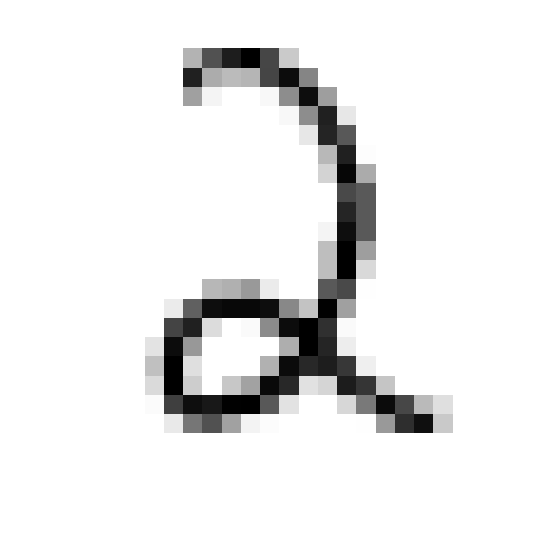

Label: 2

Model Outputs: tensor([[-1.6130,  2.3400,  9.7786,  0.2418,  0.2241, -1.8748,  2.0296, -2.0613,
         -2.4740, -6.5300]], grad_fn=<AddmmBackward0>)

Prediction: 2


In [12]:
image, label = test_dataset[47]

plt.figure(figsize=(7, 7))
plt.imshow(image.squeeze(), cmap=plt.cm.binary)
plt.axis(False)
plt.show()

outputs = model(image)

print(f"Label: {label}\n")
print(f"Model Outputs: {outputs}\n")
print(f"Prediction: {torch.argmax(outputs)}")